#  
# by: Montaser Mohammedalamen
# Date: 3 Feb 2019

### Importing Libaraies 

In [20]:
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh

import pandas as pd
import numpy as np
from numpy import linalg as LA

import sklearn
from sklearn import metrics
from sklearn import linear_model as lm
from sklearn import svm
from sklearn.model_selection import cross_val_score as cvs
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

### Read Data from text file and convert it to numpy arraies

In [24]:
xtrain=pd.read_table('Data/xtrain.txt',header=None)
xtrain=np.array(xtrain)
xtrain=xtrain.T[1:,]# remove the first colume

ytrain = pd.read_csv('Data/ytrain.txt',header=None)
ytrain=np.array(ytrain)

xtest=pd.read_table('Data/xtest.txt',header=None)
xtest=np.array(xtest)
xtest=xtest.T[1:,]# remove the first colume

print('xtrain shape',xtrain.shape)
print('ytrain shape',ytrain.shape)
print('xtest  shape',xtest.shape)

xtrain shape (184, 4654)
ytrain shape (184, 1)
xtest  shape (92, 4654)


### plot labels to show that this data is unbalanced

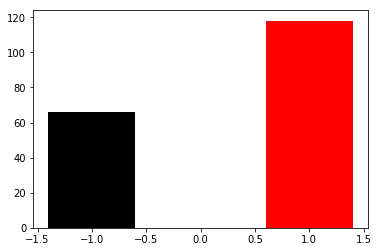

In [6]:
# plt.hist(ytrain,label='Unbalanced Data',histtype='barstacked',orientation='horizontal')
plt.bar([-1,1],[np.count_nonzero(ytrain==1),np.count_nonzero(ytrain==-1)],color=['black', 'red'])
plt.show()

### Creat Balanced Data

In [7]:
def balance_data (xtrain,ytrain): 
    x_y=np.zeros((184,4655))
    neg_index=0
    for i in range (ytrain.shape[0]):
        if ytrain[i,0]==1:
            x_y[i]=np.concatenate((xtrain[i+1],ytrain[i]))
        else:
            while neg_index ==66: 
                break
            else:    
                neg_index+=1
                x_y[i]=np.concatenate((xtrain[i+1],ytrain[i]))
    x_y=x_y[~np.all(x_y == 0, axis=1)]
    xtrain_balance=x_y[:,0:4654]
    ytrain_balance=x_y[:,4654:]
    return xtrain_balance,ytrain_balance

In [8]:
xtrain_balance,ytrain_balance=balance_data (xtrain,ytrain)

### Kernel PCA

In [9]:
def stepwise_kpca(X, gamma=0.0001, n_components=123):
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    K = exp(-gamma * mat_sq_dists)
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    eigvals, eigvecs = eigh(K)
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))
    return X_pc

### Features Selection

### Cross Validation Single SVM

In [14]:
def cross_validation_SVM (xtrain,ytrain,number_exp=5):
    acc=[]
    score=[]
    under_curve=[]
    for j in range (number_exp):
        rand_nu=np.random.randint(0,100)
        X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size=0.2, random_state=rand_nu)
        clf = svm.SVC(gamma='scale', decision_function_shape='ovo',probability=True)
        clf.fit(X_train, y_train.reshape(-1,))
        acc.append(clf.score(X_test,y_test)*100)
        prob=clf.decision_function(X_test)
        ror= metrics.roc_auc_score(y_test,prob)
        under_curve.append(ror)
    print('total accuercy form {} experiments = {:.2f} %     std= {:.2f}'.format(number_exp,np.mean(acc),np.std(acc)))
    print('the total area under the curve = {:.2f}      std= {:.2f}'.format(np.mean(under_curve),np.std(under_curve)))
    return np.mean(under_curve)

### Cross Validation voting from 3 SVMs

In [15]:
def cross_validation_multi_SVM (xtrain,ytrain,number_exp=5, number_GP=3):
    acc=[]
    score=[]
    under_curve=[]
    for j in range (number_exp):
        rand_nu=np.random.randint(0,100)
        X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size=0.2, random_state=rand_nu)
#         for g in range (number_GP):
        clf1 = svm.SVC(gamma='scale', decision_function_shape='ovo',probability=True)
        clf1.fit(X_train, y_train.reshape(-1,))
        clf2 = svm.SVC(gamma='scale', decision_function_shape='ovo',probability=True)
        clf2.fit(X_train, y_train.reshape(-1,))
        clf3 = svm.SVC(gamma='scale', decision_function_shape='ovo',probability=True)
        clf3.fit(X_train, y_train.reshape(-1,))
        vote=VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
        vote.fit(X_train, y_train.reshape(-1,))
        acc.append(vote.score(X_test,y_test)*100)
#         prob=vote.predict(X_test)
        prob=vote.predict_proba(X_test)
        ror= metrics.roc_auc_score(y_test,prob[:,1])
        under_curve.append(ror)
    print('total accuercy form {} experiments = {:.2f} %     std= {:.2f}'.format(number_exp,np.mean(acc),np.std(acc)))
    print('the total area under the curve = {:.2f}      std= {:.2f}'.format(np.mean(under_curve),np.std(under_curve)))
    return np.mean(under_curve)

### Test 

## Xtrain, ytrain

In [19]:
print('Single SVM')
cross_validation_SVM(xtrain,ytrain)
print('Multi SVMs')
cross_validation_multi_SVM(xtrain,ytrain)

Single SVM
total accuercy form 5 experiments = 65.41 %     std= 6.92
the total area under the curve = 0.71      std= 0.04
Multi SVMs
total accuercy form 5 experiments = 59.46 %     std= 4.83
the total area under the curve = 0.61      std= 0.06


0.6120456704420898

### PCA

In [18]:
X_pc_unbalance= stepwise_kpca(xtrain,gamma=0.00001,n_components=99)
print('Single SVM')
cross_validation_SVM(X_pc_unbalance,ytrain)
print('Multi SVMs')
cross_validation_multi_SVM(X_pc_unbalance,ytrain)

Single SVM
total accuercy form 5 experiments = 59.46 %     std= 2.96
the total area under the curve = 0.61      std= 0.04
Multi SVMs
total accuercy form 5 experiments = 64.86 %     std= 5.92
the total area under the curve = 0.60      std= 0.03


0.5972856772856773